In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.FeatExtModels import *


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Data

In [3]:
DATA = np.load('./Data/AsanTRSet.npy')

#### Env setting

In [77]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
### Model checkpoint
FXMLoadName = save_path+'FeatExtM.hdf5'
ModelSaveSameName = save_path+'FeatGenM.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=500)

LatDim1 = 2
LatDim2 = 2
SigDim = DATA.shape[1]
MaskingRate = 0.025
GaussStd1 = 0.002
GaussStd2 = 0.1


### Feat Extractor load

In [78]:
EncModel = EncoderModel(SigDim, Type = 'FX', LatDim= LatDim1, MaskingRate = MaskingRate, GaussStd1 = GaussStd1, GaussStd2 = GaussStd2, training=True)
FeExModel = FeatExtractModel(SigDim=SigDim)
DecModel = DecoderModel(SigDim=SigDim)
VaeSFModel = VaeModel(EncModel,FeExModel, DecModel )
VaeSFModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"Out":'mse'})

### Vae Loss; KL Divergence
Z_Sampled, Z_Log_Sigma = EncModel.get_layer('Z_Mean_FX').output,EncModel.get_layer('Z_Log_Sigma_FX').output
kl_Loss = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss = tf.reduce_mean(kl_Loss )
VaeSFModel.add_loss(kl_Loss )
VaeSFModel.add_metric(kl_Loss, 'KL_D')
VaeSFModel.load_weights(FXMLoadName)

VaeSFModel.summary()

Model: "VaeSFModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_25 (TFOpLambda) (None, 10, 100)      0           input_25[0][0]                   
__________________________________________________________________________________________________
gaussian_noise_19 (GaussianNois (None, 10, 100)      0           tf.signal.frame_25[0][0]         
__________________________________________________________________________________________________
tf.compat.v1.shape_76 (TFOpLamb (3,)                 0           gaussian_noise_19[0][0]          
_________________________________________________________________________________________

In [45]:
HpSig_21 = FeExModel.get_layer('HpSig_21').output[:,:,0]
LpSig_21 = FeExModel.get_layer('LpSig_21').output[:,:,0]
HpSig_22 = FeExModel.get_layer('HpSig_22').output[:,:,0]
LpSig_22 = FeExModel.get_layer('LpSig_22').output[:,:,0]

LatM = Model(FeExModel.input, tf.concat([HpSig_21, LpSig_21, HpSig_22, LpSig_22 ], axis=1))

Pred_ZMean = Model(EncModel.input, EncModel.get_layer('Z_Mean_FX').output).predict(DATA[:], batch_size= 2000, verbose=1)
PredLat = LatM.predict([DATA[:],Pred_ZMean], batch_size= 2000, verbose=1 )
#np.save("./Data/PredLat.npy", PredLat)

200/200 [==============================] - 10s 48ms/step


In [107]:
def FeatGenModel(LatDim= 10):


    InpZ = Input(shape=(LatDim,), name='InpZmean')
    DenseZ = Dense(10, activation='relu')(InpZ)
    DenseZ = Dense(10, activation='relu')(DenseZ)
    DenseZ = Dense(10, activation='relu')(DenseZ)

    HpSig_21 = Dense(10, activation='relu')(DenseZ)
    LpSig_21 = Dense(10, activation='relu')(DenseZ)
    HpSig_22 = Dense(10, activation='relu')(DenseZ)
    LpSig_22 = Dense(10, activation='relu')(DenseZ)

    HpSig_21 = RepeatVector((3) )(HpSig_21)
    LpSig_21 = RepeatVector((4) )(LpSig_21)
    HpSig_22 = RepeatVector((5) )(HpSig_22)
    LpSig_22 = RepeatVector((6) )(LpSig_22)

    HpSig_21 = Bidirectional(GRU(5, return_sequences=True))(HpSig_21)
    HpSig_21 = TimeDistributed(Dense(10,activation='tanh'))(HpSig_21)
    HpSig_21 = Bidirectional(GRU(10, return_sequences=True))(HpSig_21)
    HpSig_21 = Bidirectional(GRU(20, return_sequences=True))(HpSig_21)
    
    LpSig_21 = Bidirectional(GRU(5, return_sequences=True))(LpSig_21)
    LpSig_21 = TimeDistributed(Dense(10,activation='tanh'))(LpSig_21)
    LpSig_21 = Bidirectional(GRU(10, return_sequences=True))(LpSig_21)
    LpSig_21 = Bidirectional(GRU(20, return_sequences=True))(LpSig_21)
    
    HpSig_22 = Bidirectional(GRU(5, return_sequences=True))(HpSig_22)
    HpSig_22 = TimeDistributed(Dense(10,activation='tanh'))(HpSig_22)
    HpSig_22 = Bidirectional(GRU(10, return_sequences=True))(HpSig_22)
    HpSig_22 = Bidirectional(GRU(20, return_sequences=True))(HpSig_22)
    
    LpSig_22 = Bidirectional(GRU(5, return_sequences=True))(LpSig_22)
    LpSig_22 = TimeDistributed(Dense(10,activation='tanh'))(LpSig_22)
    LpSig_22 = Bidirectional(GRU(10, return_sequences=True))(LpSig_22)
    LpSig_22 = Bidirectional(GRU(20, return_sequences=True))(LpSig_22)

    HpSig_21 = TimeDistributed(Dense(100,activation='tanh'))(HpSig_21)
    LpSig_21 = TimeDistributed(Dense(100,activation='tanh'))(LpSig_21)
    HpSig_22 = TimeDistributed(Dense(100,activation='tanh'))(HpSig_22)
    LpSig_22 = TimeDistributed(Dense(100,activation='tanh'))(LpSig_22)
    
    GenOut = tf.concat([Flatten()(HpSig_21), Flatten()(LpSig_21), Flatten()(HpSig_22), Flatten()(LpSig_22)], axis=1)
    
    FeatGenM = Model(InpZ, GenOut, name='FeatGenModel')
    
    return FeatGenM



<KerasTensor: shape=(None, 1800) dtype=float32 (created by layer 'FeatGenModel')>

### Vae Loss; RecMSE and KL Divergence

In [108]:
EncModel_FG = EncoderModel(SigDim, Type = 'FG', LatDim= LatDim2, MaskingRate = MaskingRate, GaussStd1 = GaussStd1, GaussStd2 = GaussStd2, training=True)
FeGenModel_ =FeatGenModel(LatDim2)
FeGenOut = FeGenModel_(EncModel_FG.get_layer('Z_Mean_FG').output)
FeGenOut = ReName(FeGenOut, 'GenOut')
FeGenModel = Model(EncModel_FG.input, FeGenOut)
FeGenModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"GenOut":'mse'})

### Vae Loss; KL Divergence
Z_Sampled, Z_Log_Sigma = EncModel_FG.get_layer('Z_Mean_FG').output,EncModel_FG.get_layer('Z_Log_Sigma_FG').output
kl_Loss = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss = tf.reduce_mean(kl_Loss )
FeGenModel.add_loss(kl_Loss )
FeGenModel.add_metric(kl_Loss, 'KL_D_FG')

FeGenModel.summary()

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_41 (TFOpLambda) (None, 10, 100)      0           input_40[0][0]                   
__________________________________________________________________________________________________
gaussian_noise_29 (GaussianNois (None, 10, 100)      0           tf.signal.frame_41[0][0]         
__________________________________________________________________________________________________
tf.compat.v1.shape_116 (TFOpLam (3,)                 0           gaussian_noise_29[0][0]          
___________________________________________________________________________________________

<KerasTensor: shape=(None, 1800) dtype=float32 (created by layer 'GenOut')>

In [ ]:
#VaeSFModel.load_weights(ModelSaveSameName)
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_loss', verbose=1, save_best_only=True )

FeGenModel.fit(DATA[:], PredLat, batch_size=1000, epochs=350, shuffle=True, validation_split=0.2, callbacks=[ModelSave, EarlyStop])

Epoch 1/350
320/320 [==============================] - 54s 122ms/step - loss: 0.0522 - mse: 0.0119 - KL_D_FG: 0.0175 - val_loss: 0.0138 - val_mse: 0.0035 - val_KL_D_FG: 0.0103

Epoch 00001: val_loss improved from inf to 0.01377, saving model to ./Results\FeatGenM.hdf5
Epoch 2/350
320/320 [==============================] - 34s 106ms/step - loss: 0.0138 - mse: 0.0035 - KL_D_FG: 0.0103 - val_loss: 0.0137 - val_mse: 0.0034 - val_KL_D_FG: 0.0103

Epoch 00002: val_loss improved from 0.01377 to 0.01372, saving model to ./Results\FeatGenM.hdf5
Epoch 3/350
320/320 [==============================] - 34s 107ms/step - loss: 0.0136 - mse: 0.0034 - KL_D_FG: 0.0101 - val_loss: 0.0138 - val_mse: 0.0034 - val_KL_D_FG: 0.0104

Epoch 00003: val_loss did not improve from 0.01372
Epoch 4/350
320/320 [==============================] - 34s 105ms/step - loss: 0.0136 - mse: 0.0034 - KL_D_FG: 0.0102 - val_loss: 0.0138 - val_mse: 0.0035 - val_KL_D_FG: 0.0104

Epoch 00004: val_loss did not improve from 0.01372
Ep

### Post analysis

In [103]:
EncModel = EncoderModel(SigDim=SigDim, training=False)
FeExModel = FeatExtractModel()
DecModel = DecoderModel()
VaeSFModel = VaeModel(EncModel,FeExModel, DecModel )

### Vae Loss; KL Divergence
Z_Sampled, Z_Log_Sigma = EncModel.get_layer('Z_Mean_ft').output,EncModel.get_layer('Z_Log_Sigma_ft').output
kl_Loss = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss = tf.reduce_mean(kl_Loss )
VaeSFModel.add_loss(kl_Loss )
VaeSFModel.add_metric(kl_Loss, 'KL_D')

VaeSFModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"Out":'mse'})
VaeSFModel.load_weights(ModelSaveSameName)


#### Rec pred by zMean

In [105]:
VaeSFModel.load_weights(ModelSaveSameName)
VaeSFModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"Out":'mse'})

#Pred =VAEM.predict(DATA[:], batch_size=1000, verbose=1)
VaeSFModel.evaluate(DATA[:], DATA[:], batch_size=2000, verbose=1)
#np.mean((DATA[:]- Pred)**2)

200/200 [==============================] - 14s 54ms/step - loss: 8.8347e-04 - mse: 8.8263e-04 - KL_D: 8.3548e-07


[0.0008857114589773118, 0.0008848761790432036, 8.35480989280768e-07]

#### Components pred

In [11]:
VaeSFModel.load_weights(ModelSaveSameName)

HpSig_11 = DecModel.get_layer('HpSig_11').output
LpSig_11 = DecModel.get_layer('LpSig_11').output
HpSig_21 = DecModel.get_layer('HpSig_21').output
LpSig_21 = DecModel.get_layer('LpSig_21').output
HpSig_22 = DecModel.get_layer('HpSig_22').output
LpSig_22 = DecModel.get_layer('LpSig_22').output

LHFs = DecModel.get_layer('LHFs').output
LHBs = DecModel.get_layer('LHBs').output

LatM = Model(DecModel.input, [HpSig_11, LpSig_11, HpSig_21, LpSig_21, HpSig_22, LpSig_22 ])
ParaM = Model(DecModel.input, [LHFs, LHBs ])


Pred_ZMean = Model(EncModel.input, EncModel.get_layer('Z_Mean').output).predict(DATA[:10])
PredLat = LatM.predict([DATA[:10],Pred_ZMean] )
PredPara = ParaM.predict([DATA[:10],Pred_ZMean] )
Pred =VaeSFModel.predict(DATA[:10])


#### Variational pred

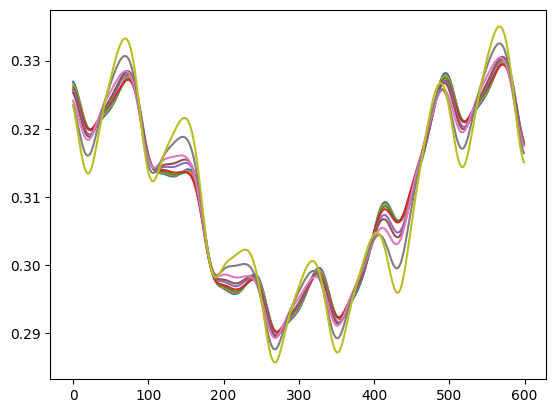

In [18]:
Pred_ZSampled = np.array([np.linspace(-30, 30, 10), np.linspace(-30, 30, 10)]).T
DataSample = np.tile(DATA[1:2].T, 10).T
PredLat = LatM.predict([DataSample,Pred_ZSampled] )

idx = 5
#plt.plot(DATA[idx])
for i in range(9):
    plt.plot(PredLat[idx][i, :1000, 0])
    #print(PredLat[i].shape)

In [19]:
PredLat[0].shape

(10, 700, 1)

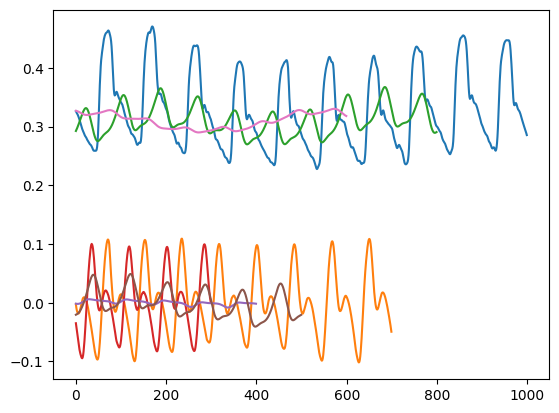

In [20]:
idx = 0
plt.plot(DATA[idx])
for i in range(6):
    plt.plot(PredLat[i][idx, :1000, 0])
    #print(PredLat[i].shape)


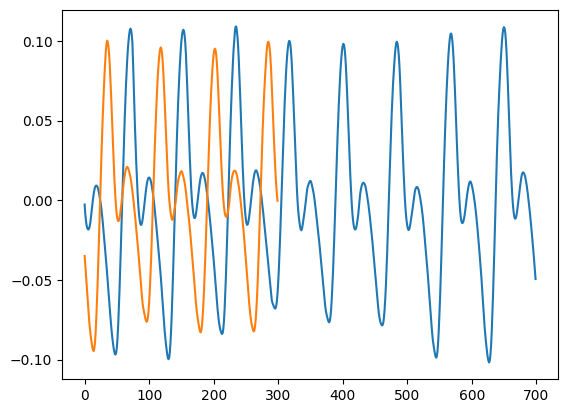

In [21]:
idx = 0
plt.plot(PredLat[0][idx, :1000, 0])
plt.plot(PredLat[2][idx, :1000, 0])


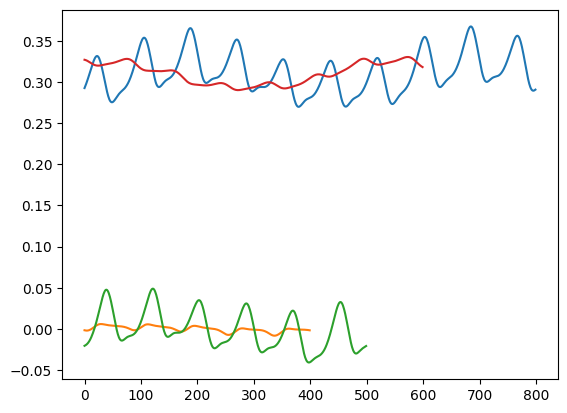

In [22]:
plt.plot(PredLat[1][idx, :, 0])
plt.plot(PredLat[3][idx, :, 0])
plt.plot(PredLat[4][idx, :, 0])
plt.plot(PredLat[5][idx, :, 0])

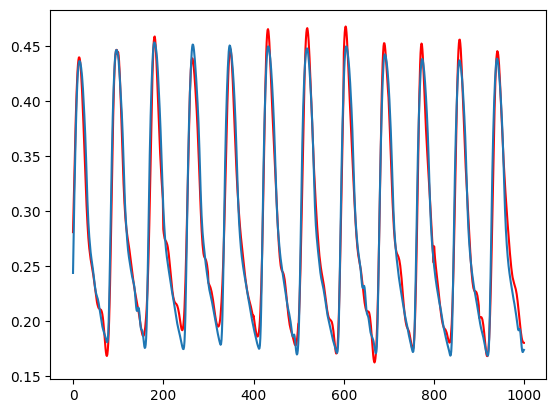

In [29]:
idx= 6
plt.plot(Pred[idx], c='red')
plt.plot(DATA[idx])


100